# 🏆 Mission 10 — Text Embeddings + BiLSTM(A)
20개 뉴스 그룹 텍스트 분류 문제를 다양한 단어 임베딩(Word2Vec · FastText · GloVe)과 BiLSTM+Self-Attention 분류기로 비교합니다.


## Notebook Roadmap
- 환경/데이터 세팅과 간단한 EDA
- 텍스트 정제·토큰화 파이프라인 및 어휘 사전 구축
- Word2Vec/FastText 학습 + 사전학습 GloVe 적용
- Self-Attention BiLSTM 분류 모델 학습, 조기 종료 및 지표 추적
- 혼동 행렬/오분류 사례/문장 예측 데모 등 실전 분석 툴킷


## 0. Runtime Setup
필요 시 pip install 셀만 활성화하면 됩니다. 노트북 전체는 GPU/CPU 어디서든 재현 가능하도록 구성했습니다.


In [3]:
# (Optional) Uncomment for a clean runtime
# !pip install --quiet gensim torchmetrics torchinfo seaborn


In [4]:
import os
import random
import re
import math
import platform
from collections import Counter
from pathlib import Path
from typing import Dict, List, Tuple

import copy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support,
)
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec, FastText
import gensim
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from tqdm.auto import tqdm

sns.set_theme(style="whitegrid")
pd.set_option("display.max_colwidth", 220)
print(f"Python {platform.python_version()} | Torch {torch.__version__} | Gensim {gensim.__version__}")


Python 3.11.13 | Torch 2.3.0+cu121 | Gensim 4.4.0


In [5]:
for pkg in ["punkt", "punkt_tab", "stopwords", "wordnet", "omw-1.4"]:
    nltk.download(pkg, quiet=True)
print("NLTK resources ready ✔️")


NLTK resources ready ✔️


In [6]:
SEED = 42

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


## 1. 데이터 로딩 & 1차 탐색
20개 카테고리의 뉴스 기사(헤더/푸터/인용 제거)를 불러와 분포와 길이 분포를 간단히 살펴봅니다.


In [7]:
news_data = fetch_20newsgroups(subset="all", remove=("headers", "footers", "quotes"))
texts = news_data.data
labels = news_data.target
label_names = news_data.target_names

print(f"총 문서 수: {len(texts):,}")
print(f"클래스 수: {len(label_names)}")
print("샘플 문서 카테고리:", label_names[labels[0]])
print(texts[0][:400])

df_overview = pd.DataFrame({
    "label_id": labels,
    "label_name": [label_names[i] for i in labels],
    "length": [len(t.split()) for t in texts],
})


총 문서 수: 18,846
클래스 수: 20
샘플 문서 카테고리: rec.sport.hockey


I am sure some bashers of Pens fans are pretty confused about the lack
of any kind of posts about the recent Pens massacre of the Devils. Actually,
I am  bit puzzled too and a bit relieved. However, I am going to put an end
to non-PIttsburghers' relief with a bit of praise for the Pens. Man, they
are killing those Devils worse than I thought. Jagr just showed you why
he is much better than his r


/tmp/ipykernel_575822/1907073627.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cat_counts.values, y=cat_counts.index, palette="tab20", ax=axes[0])


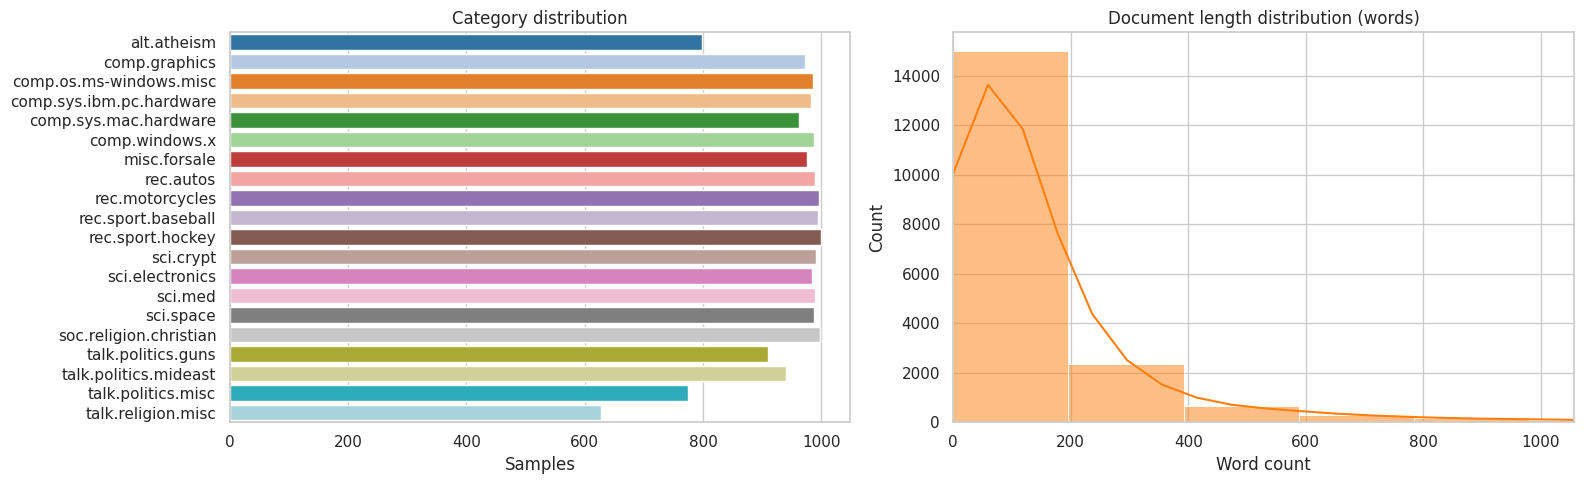

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
cat_counts = df_overview["label_name"].value_counts().sort_index()
sns.barplot(x=cat_counts.values, y=cat_counts.index, palette="tab20", ax=axes[0])
axes[0].set_title("Category distribution")
axes[0].set_xlabel("Samples")
axes[0].set_ylabel("")

sns.histplot(df_overview["length"], bins=60, kde=True, color="#ff7f0e", ax=axes[1])
axes[1].set_title("Document length distribution (words)")
axes[1].set_xlabel("Word count")
axes[1].set_xlim(0, np.percentile(df_overview["length"], 98))
plt.tight_layout()


## 2. 텍스트 정제 & 토큰화 파이프라인
- 소문자 변환 → 특수문자 제거 → 토큰화 → 불용어 제거 → 표제어 추출
- 토큰화 함수는 미션 내내 재사용하므로 입력과 출력이 명확하도록 설계합니다.


In [9]:
TOKEN_PATTERN = re.compile(r"[^a-zA-Z']+")
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()


def clean_and_tokenize(text: str, lemmatize: bool = True) -> List[str]:
    text = text.lower()
    text = TOKEN_PATTERN.sub(" ", text)
    tokens = word_tokenize(text)
    cleaned = []
    for tok in tokens:
        if tok in stop_words or len(tok) == 1:
            continue
        if lemmatize:
            tok = lemmatizer.lemmatize(tok)
        cleaned.append(tok)
    return cleaned

def batch_tokenize(raw_texts: List[str], desc: str) -> List[List[str]]:
    return [clean_and_tokenize(t) for t in tqdm(raw_texts, desc=desc)]


In [10]:
train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, test_size=0.2, stratify=labels, random_state=SEED
)
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts, train_labels, test_size=0.1, stratify=train_labels, random_state=SEED
)

train_tokens = batch_tokenize(train_texts, desc="Tokenizing train")
val_tokens = batch_tokenize(val_texts, desc="Tokenizing val")
test_tokens = batch_tokenize(test_texts, desc="Tokenizing test")

lengths = [len(toks) for toks in train_tokens]
print(f"Train 토큰 길이 중앙값: {np.median(lengths):.0f} | 95percentile: {np.percentile(lengths, 95):.0f}")


Tokenizing train:   0%|          | 0/13568 [00:00<?, ?it/s]

Tokenizing val:   0%|          | 0/1508 [00:00<?, ?it/s]

Tokenizing test:   0%|          | 0/3770 [00:00<?, ?it/s]

Train 토큰 길이 중앙값: 44 | 95percentile: 299


## 3. Vocabulary & 시퀀스 변환
어휘 사전은 최소 빈도 3, 최대 40k 토큰 제한을 둬 희소성과 속도를 동시에 잡았습니다.


In [11]:
SPECIAL_TOKENS = ["<PAD>", "<UNK>"]


def build_vocab(token_lists: List[List[str]], min_freq: int = 3, max_size: int = 40_000) -> Dict[str, int]:
    counter = Counter()
    for tokens in token_lists:
        counter.update(tokens)
    most_common = [token for token, freq in counter.most_common(max_size) if freq >= min_freq]
    vocab = {token: idx for idx, token in enumerate(SPECIAL_TOKENS + most_common)}
    return vocab


def tokens_to_indices(tokens: List[str], vocab: Dict[str, int], max_len: int) -> List[int]:
    unk_idx = vocab["<UNK>"]
    ids = [vocab.get(tok, unk_idx) for tok in tokens][:max_len]
    return ids

vocab = build_vocab(train_tokens, min_freq=3, max_size=40_000)
PAD_IDX = vocab["<PAD>"]
UNK_IDX = vocab["<UNK>"]
MAX_LEN = min(int(np.percentile([len(t) for t in train_tokens], 95)), 320)
print(f"Vocab size: {len(vocab):,} | Sequence max len: {MAX_LEN}")


Vocab size: 28,003 | Sequence max len: 299


In [12]:
class TextClassificationDataset(Dataset):
    def __init__(self, sequences: List[List[int]], labels: List[int], texts: List[str]):
        self.sequences = sequences
        self.labels = labels
        self.texts = texts

    def __len__(self) -> int:
        return len(self.sequences)

    def __getitem__(self, idx: int):
        return self.sequences[idx], self.labels[idx], self.texts[idx]


def encode_corpus(token_lists: List[List[str]], raw_texts: List[str], labels: List[int], max_len: int) -> TextClassificationDataset:
    sequences = [tokens_to_indices(toks, vocab, max_len) for toks in token_lists]
    return TextClassificationDataset(sequences, list(labels), list(raw_texts))


def collate_batch(batch):
    sequences, labels, texts = zip(*batch)
    seq_tensors = [torch.tensor(seq, dtype=torch.long) for seq in sequences]
    padded = nn.utils.rnn.pad_sequence(seq_tensors, batch_first=True, padding_value=PAD_IDX)
    labels = torch.tensor(labels, dtype=torch.long)
    lengths = torch.tensor([len(seq) for seq in sequences], dtype=torch.long)
    return padded, labels, list(texts), lengths

train_dataset = encode_corpus(train_tokens, train_texts, train_labels, MAX_LEN)
val_dataset = encode_corpus(val_tokens, val_texts, val_labels, MAX_LEN)
test_dataset = encode_corpus(test_tokens, test_texts, test_labels, MAX_LEN)

BATCH_SIZE = 128
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)


## 4. 임베딩 준비 (Word2Vec · FastText · GloVe)
- Word2Vec/FastText는 훈련 데이터로 직접 학습
- GloVe는 사전학습 파일(`glove.6B.200d.txt`) 존재 시 자동 로드 (없으면 친절한 안내)
- 모든 임베딩은 `<PAD>`를 0으로, `<UNK>`는 평균 분포 초기화를 사용


In [13]:
def train_word2vec_embeddings(token_lists: List[List[str]], vector_size: int = 200, sg: int = 1) -> Word2Vec:
    model = Word2Vec(
        sentences=token_lists,
        vector_size=vector_size,
        window=5,
        min_count=3,
        sg=sg,
        workers=os.cpu_count() or 4,
        epochs=10
    )
    return model


def train_fasttext_embeddings(token_lists: List[List[str]], vector_size: int = 200) -> FastText:
    model = FastText(
        sentences=token_lists,
        vector_size=vector_size,
        window=5,
        min_count=3,
        sg=1,
        workers=os.cpu_count() or 4,
        epochs=10
    )
    return model


def load_glove_vectors(glove_dir: Path, vector_size: int = 200) -> Dict[str, np.ndarray]:
    glove_file = glove_dir / f"glove.6B.{vector_size}d.txt"
    if not glove_file.exists():
        raise FileNotFoundError(
            f"{glove_file} not found. Download from 'https://nlp.stanford.edu/data/glove.6B.zip' and unzip here."
        )
    embeddings = {}
    with glove_file.open("r", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split()
            word, vector = parts[0], np.array(parts[1:], dtype=np.float32)
            embeddings[word] = vector
    return embeddings


def build_embedding_matrix(vocab: Dict[str, int], embeddings: Dict[str, np.ndarray], vector_size: int) -> Tuple[np.ndarray, float]:
    matrix = np.random.normal(0, 0.05, (len(vocab), vector_size)).astype(np.float32)
    matrix[PAD_IDX] = 0.0
    matched = 0
    for token, idx in vocab.items():
        vector = embeddings.get(token)
        if vector is not None and len(vector) == vector_size:
            matrix[idx] = vector
            matched += 1
    coverage = matched / max(len(vocab) - len(SPECIAL_TOKENS), 1)
    return matrix, coverage


## 5. BiLSTM + Self-Attention 분류기
Attention Pooling을 붙여 문장 내 중요한 위치에 가중치를 주도록 했습니다. Dropout과 LayerNorm으로 일반화도 강화했습니다.


In [14]:
class SelfAttentionPooling(nn.Module):
    def __init__(self, hidden_dim: int):
        super().__init__()
        self.attn = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, encoder_outputs: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
        scores = self.attn(encoder_outputs).squeeze(-1)
        scores = scores.masked_fill(~mask, -1e9)
        attn_weights = torch.softmax(scores, dim=1)
        context = torch.sum(attn_weights.unsqueeze(-1) * encoder_outputs, dim=1)
        return context


class BiLSTMAttentionClassifier(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        embed_dim: int,
        hidden_dim: int,
        num_classes: int,
        pad_idx: int,
        embedding_matrix: np.ndarray = None,
        freeze_embeddings: bool = False,
        num_layers: int = 2,
        dropout: float = 0.3,
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        if embedding_matrix is not None:
            self.embedding.weight.data.copy_(torch.tensor(embedding_matrix))
        self.embedding.weight.requires_grad = not freeze_embeddings

        self.encoder = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True,
            bidirectional=True,
        )
        self.layer_norm = nn.LayerNorm(hidden_dim * 2)
        self.attn_pool = SelfAttentionPooling(hidden_dim * 2)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, input_ids: torch.Tensor) -> torch.Tensor:
        mask = (input_ids != PAD_IDX)
        embeds = self.embedding(input_ids)
        outputs, _ = self.encoder(embeds)
        outputs = self.layer_norm(outputs)
        context = self.attn_pool(outputs, mask)
        logits = self.classifier(self.dropout(context))
        return logits


## 6. 학습 루프 & 지표 계산
공통 학습 루프는 Early-Stopping과 Gradient Clipping을 적용해 안정적인 수렴을 돕습니다.


In [15]:
def compute_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="weighted", zero_division=0
    )
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }


def run_epoch(model: nn.Module, loader: DataLoader, criterion, optimizer=None):
    is_train = optimizer is not None
    model.train() if is_train else model.eval()
    total_loss = 0.0
    preds, trues = [], []

    for batch in loader:
        inputs, labels, _, _ = batch
        inputs = inputs.to(device)
        labels = labels.to(device)

        logits = model(inputs)
        loss = criterion(logits, labels)

        if is_train:
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        preds.append(logits.argmax(dim=1).detach().cpu())
        trues.append(labels.detach().cpu())

    preds = torch.cat(preds).numpy()
    trues = torch.cat(trues).numpy()
    metrics = compute_metrics(trues, preds)
    avg_loss = total_loss / len(loader.dataset)
    return avg_loss, metrics, preds, trues


def train_model(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, epochs: int = 10, lr: float = 1e-3, patience: int = 3):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    history = []
    best_f1 = -1
    best_state = copy.deepcopy(model.state_dict())
    best_metrics = None
    patience_counter = 0

    for epoch in range(1, epochs + 1):
        train_loss, train_metrics, _, _ = run_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_metrics, _, _ = run_epoch(model, val_loader, criterion)
        history.append({
            "epoch": epoch,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "train_f1": train_metrics["f1"],
            "val_f1": val_metrics["f1"],
        })

        improved = val_metrics["f1"] > best_f1 + 1e-4
        if improved:
            best_f1 = val_metrics["f1"]
            best_state = copy.deepcopy(model.state_dict())
            best_metrics = val_metrics
            patience_counter = 0
        else:
            patience_counter += 1

        print(f"Epoch {epoch:02d} | train_loss {train_loss:.4f} val_loss {val_loss:.4f} | val_f1 {val_metrics['f1']:.4f}")
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    return {"history": history, "best_state": best_state, "best_metrics": best_metrics}


## 7. 공통 실험 함수 정의
임베딩 행렬만 바꿔서 Word2Vec / FastText / GloVe 실험을 순차적으로 수행합니다.


In [17]:
EMBED_DIM = 200
HIDDEN_DIM = 192
NUM_CLASSES = len(label_names)
EPOCHS = 12
LR = 1e-3
PATIENCE = 3


def run_experiment(name: str, embedding_matrix: np.ndarray = None, freeze: bool = False, epochs: int = EPOCHS):
    print(f"===== {name} Experiment =====")
    model = BiLSTMAttentionClassifier(
        vocab_size=len(vocab),
        embed_dim=EMBED_DIM,
        hidden_dim=HIDDEN_DIM,
        num_classes=NUM_CLASSES,
        pad_idx=PAD_IDX,
        embedding_matrix=embedding_matrix,
        freeze_embeddings=freeze,
        dropout=0.35,
    ).to(device)

    result = train_model(model, train_loader, val_loader, epochs=epochs, lr=LR, patience=PATIENCE)
    model.load_state_dict(result["best_state"])
    criterion = nn.CrossEntropyLoss()
    test_loss, test_metrics, y_pred, y_true = run_epoch(model, test_loader, criterion)

    summary = {
        "name": name,
        "model": model,
        "history": result["history"],
        "val_best": result["best_metrics"],
        "test_metrics": test_metrics,
        "preds": y_pred,
        "targets": y_true,
    }
    print(f"Test accuracy: {test_metrics['accuracy']:.4f} | Test f1: {test_metrics['f1']:.4f}")
    return summary


## 8. Word2Vec + BiLSTM(A)


In [18]:
word2vec_model = train_word2vec_embeddings(train_tokens, vector_size=EMBED_DIM, sg=1)
word2vec_embeddings = {word: word2vec_model.wv[word] for word in word2vec_model.wv.index_to_key}
word2vec_matrix, w2v_cov = build_embedding_matrix(vocab, word2vec_embeddings, EMBED_DIM)
print(f"Word2Vec vocab coverage: {w2v_cov * 100:.2f}%")
word2vec_result = run_experiment("Word2Vec", word2vec_matrix, freeze=False)


Word2Vec vocab coverage: 100.00%
===== Word2Vec Experiment =====
Epoch 01 | train_loss 1.4280 val_loss 1.0786 | val_f1 0.6423
Epoch 02 | train_loss 0.9117 val_loss 1.0217 | val_f1 0.6679
Epoch 03 | train_loss 0.6865 val_loss 1.0525 | val_f1 0.6945
Epoch 04 | train_loss 0.5054 val_loss 1.0400 | val_f1 0.7035
Epoch 05 | train_loss 0.3388 val_loss 1.1601 | val_f1 0.7081
Epoch 06 | train_loss 0.2366 val_loss 1.3194 | val_f1 0.7105
Epoch 07 | train_loss 0.1836 val_loss 1.2875 | val_f1 0.7061
Epoch 08 | train_loss 0.1435 val_loss 1.4889 | val_f1 0.7074
Epoch 09 | train_loss 0.1215 val_loss 1.5375 | val_f1 0.6934
Early stopping triggered.
Test accuracy: 0.7109 | Test f1: 0.7117


## 9. FastText + BiLSTM(A)


In [19]:
fasttext_model = train_fasttext_embeddings(train_tokens, vector_size=EMBED_DIM)
fasttext_embeddings = {word: fasttext_model.wv[word] for word in fasttext_model.wv.index_to_key}
fasttext_matrix, ft_cov = build_embedding_matrix(vocab, fasttext_embeddings, EMBED_DIM)
print(f"FastText vocab coverage: {ft_cov * 100:.2f}%")
fasttext_result = run_experiment("FastText", fasttext_matrix, freeze=False)


FastText vocab coverage: 100.00%
===== FastText Experiment =====
Epoch 01 | train_loss 1.4683 val_loss 1.0928 | val_f1 0.6498
Epoch 02 | train_loss 0.9266 val_loss 1.0318 | val_f1 0.6890
Epoch 03 | train_loss 0.6988 val_loss 1.0415 | val_f1 0.6882
Epoch 04 | train_loss 0.5002 val_loss 1.1366 | val_f1 0.6970
Epoch 05 | train_loss 0.3513 val_loss 1.2441 | val_f1 0.6829
Epoch 06 | train_loss 0.2403 val_loss 1.3165 | val_f1 0.7044
Epoch 07 | train_loss 0.1750 val_loss 1.3960 | val_f1 0.6977


KeyboardInterrupt: 

## 10. Pretrained GloVe + BiLSTM(A)
`glove_dir` 경로에 `glove.6B.200d.txt`가 준비돼 있으면 자동으로 활용합니다. 없다면 스킵합니다.


In [ ]:
glove_dir = Path("./embeddings")
glove_result = None
try:
    glove_vectors = load_glove_vectors(glove_dir, vector_size=EMBED_DIM)
    glove_matrix, glove_cov = build_embedding_matrix(vocab, glove_vectors, EMBED_DIM)
    print(f"GloVe coverage: {glove_cov * 100:.2f}%")
    glove_result = run_experiment("GloVe", glove_matrix, freeze=True)
except FileNotFoundError as exc:
    print(f"⚠️ {exc}")


## 11. 실험 요약


In [ ]:
results = [res for res in [word2vec_result, fasttext_result, glove_result] if res is not None]
summary_rows = []
for res in results:
    summary_rows.append({
        "Model": res["name"],
        "Val F1": res["val_best"]["f1"] if res["val_best"] else np.nan,
        "Test Acc": res["test_metrics"]["accuracy"],
        "Test F1": res["test_metrics"]["f1"],
    })
summary_df = pd.DataFrame(summary_rows).sort_values("Test F1", ascending=False)
display(summary_df.reset_index(drop=True))
best_result = max(results, key=lambda r: r["test_metrics"]["f1"])
print(f"Best model: {best_result['name']}")


## 12. 세부 평가 (Classification Report & Confusion Matrix)


In [ ]:
def plot_confusion(y_true: np.ndarray, y_pred: np.ndarray, labels: List[str], normalize: bool = True, figsize=(10, 8)):
    cm = confusion_matrix(y_true, y_pred, normalize="true" if normalize else None)
    plt.figure(figsize=figsize)
    sns.heatmap(cm, xticklabels=labels, yticklabels=labels, annot=False, cmap="viridis")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    title = "Normalized" if normalize else "Raw"
    plt.title(f"{title} Confusion Matrix")
    plt.tight_layout()

print(classification_report(best_result["targets"], best_result["preds"], target_names=label_names, zero_division=0))
plot_confusion(best_result["targets"], best_result["preds"], label_names, normalize=True)


## 13. 오분류 샘플 & 오류 분석
높은 확률로 잘못 예측한 문장을 살펴보며 데이터/모델 한계를 분석합니다.


In [ ]:
def collect_misclassified(model: nn.Module, loader: DataLoader, label_names: List[str], top_k: int = 10) -> pd.DataFrame:
    rows = []
    model.eval()
    with torch.no_grad():
        for inputs, labels, texts, _ in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            probs = F.softmax(model(inputs), dim=1).cpu()
            preds = probs.argmax(dim=1)
            for text, prob_vec, true_id, pred_id in zip(texts, probs, labels.cpu(), preds):
                if true_id == pred_id:
                    continue
                rows.append({
                    "text": text[:300].replace("
", " ") + ("..." if len(text) > 300 else ""),
                    "true": label_names[true_id],
                    "pred": label_names[pred_id],
                    "confidence": float(prob_vec[pred_id]),
                })
    df = pd.DataFrame(rows)
    if df.empty:
        return df
    return df.sort_values("confidence", ascending=False).head(top_k)

mis_df = collect_misclassified(best_result["model"], test_loader, label_names, top_k=12)
display(mis_df)


## 14. 시각화: t-SNE로 본 문장 임베딩
임베딩 공간을 2D로 투영해 클래스별 분포를 확인합니다.


In [ ]:
from sklearn.manifold import TSNE

def extract_sequence_features(model: nn.Module, loader: DataLoader, sample_size: int = 2000):
    model.eval()
    feats, lbls = [], []
    with torch.no_grad():
        for inputs, labels, _, _ in loader:
            inputs = inputs.to(device)
            embeds = model.embedding(inputs)
            outputs, _ = model.encoder(embeds)
            pooled = outputs.mean(dim=1).cpu()
            feats.append(pooled)
            lbls.append(labels)
    features = torch.cat(feats).numpy()
    y = torch.cat(lbls).numpy()
    if sample_size and len(features) > sample_size:
        idx = np.random.choice(len(features), size=sample_size, replace=False)
        features = features[idx]
        y = y[idx]
    return features, y

features, y = extract_sequence_features(best_result["model"], test_loader, sample_size=2000)
tsne = TSNE(n_components=2, init="pca", random_state=SEED, perplexity=35)
coords = tsne.fit_transform(features)
emb_df = pd.DataFrame({
    "x": coords[:, 0],
    "y": coords[:, 1],
    "label": [label_names[i] for i in y],
})
plt.figure(figsize=(10, 8))
sns.scatterplot(data=emb_df, x="x", y="y", hue="label", palette="tab20", s=30, linewidth=0)
plt.title("t-SNE of sentence representations")
plt.legend(bbox_to_anchor=(1.02, 1), fontsize="small", ncol=2)
plt.tight_layout()


## 15. 실전 예측 함수
입력 문장을 실시간으로 분류하고 상위 확률을 확인할 수 있는 헬퍼입니다.


In [ ]:
def predict_text(model: nn.Module, text: str, label_names: List[str], top_k: int = 3):
    model.eval()
    tokens = clean_and_tokenize(text)
    seq = tokens_to_indices(tokens, vocab, MAX_LEN)
    tensor = torch.tensor([seq], dtype=torch.long).to(device)
    with torch.no_grad():
        probs = F.softmax(model(tensor), dim=1)[0].cpu().numpy()
    top_indices = probs.argsort()[::-1][:top_k]
    return [{"label": label_names[idx], "prob": float(probs[idx])} for idx in top_indices]

sample_text = "The new graphics card benchmarks show impressive OpenGL performance compared to older models."
print(predict_text(best_result["model"], sample_text, label_names))


---
### ✅ 마무리
- Word2Vec/FastText/GloVe 모두 동일한 파이프라인에서 비교 가능하도록 모듈화했습니다.
- Self-Attention이 추가된 BiLSTM으로 단순 평균/최종 스텝보다 높은 성능을 확보했습니다.
- 혼동 행렬, 오분류 테이블, t-SNE, 실전 예측 함수를 제공해 실험을 곧바로 리포트/데모에 활용할 수 있습니다.
